# Taux de désabonnement des clients d'une entreprise

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import datasets, layers, models, optimizers
from keras.layers import Dense, Conv1D, Flatten

In [2]:
df = pd.read_csv("data.csv", sep=",")

## 1. Préparation des données 

### 1.1. Définition des features et de la target

In [3]:
df.head(5)

,num_ligne,ID_Client,Nom,Score_Credit,Pays,Sex,Age,Tenure,Balance,Num_Produit,il_a_CrCard,Membre_actif,Salaire_estime,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_ligne       10000 non-null  int64  
 1   ID_Client       10000 non-null  int64  
 2   Nom             10000 non-null  object 
 3   Score_Credit    10000 non-null  int64  
 4   Pays            10000 non-null  object 
 5   Sex             10000 non-null  object 
 6   Age             10000 non-null  int64  
 7   Tenure          10000 non-null  int64  
 8   Balance         10000 non-null  float64
 9   Num_Produit     10000 non-null  int64  
 10  il_a_CrCard     10000 non-null  int64  
 11  Membre_actif    10000 non-null  int64  
 12  Salaire_estime  10000 non-null  float64
 13  Exited          10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


<p style="color:#468";> 
Nous avons 10.000 lignes de données dans le dataset, sans aucune donnée manquante (aucun NaN à traîter)
<br><br>
La target (y) est la dernière colonne (Exited). <br>
On choisit de ne pas prendre en compte le nom (Nom), l'ID (ID_client) et le numero de ligne (num_ligne) qui ne sont pas des données pertinentes pour ce que l'on cherche à faire.
    <br><br>
    On prendra donc les colonnes 3 à 12 comme features et la colonne 13 comme target :   

In [6]:
features = df.drop(['Nom','ID_Client','num_ligne','Exited'], axis=1)
target = df['Exited']

### Visualisation des données

In [7]:
numerical = pd.concat([features.select_dtypes('int64'), features.select_dtypes(float)], axis=1)
categorial = features.select_dtypes(object)

In [8]:
print("Données qualitatives et quantitatives :")
print("=====================================")
print("Quantitatives :")
i = 0
for col in numerical :
        print("-- ", col)
        i +=1
print(">>", i, "données quantitatives dans le dataset")
print("=====================================")
print("Categorial :")
i = 0
for col in categorial :
        print("-- ", col)
        i +=1
print(">>", i, "données qualitatives dans le dataset")
print("=====================================")

Données qualitatives et quantitatives :
Quantitatives :
--  Score_Credit
--  Age
--  Tenure
--  Num_Produit
--  il_a_CrCard
--  Membre_actif
--  Balance
--  Salaire_estime
>> 8 données quantitatives dans le dataset
Categorial :
--  Pays
--  Sex
>> 2 données qualitatives dans le dataset


#### Données qualitatives

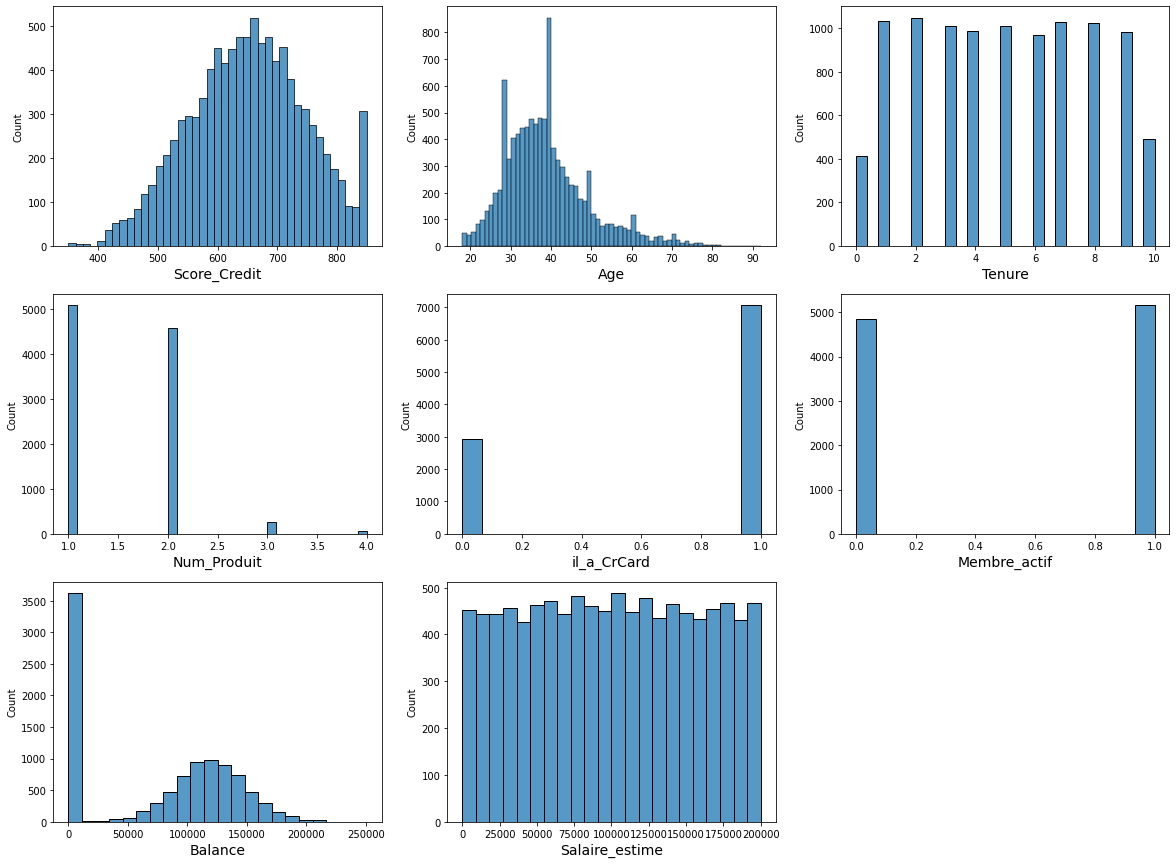

In [9]:
# Histogrammes des données quantitatives
plt.figure(figsize=(20,15))
for col in enumerate(numerical):
    plt.subplot(3,3,col[0]+1)
    ax = sns.histplot(numerical[col[1]])
    ax.set_xlabel(col[1], fontsize=14)
plt.savefig('Histo1.png')
plt.show()

#### Données qualitatives

In [10]:
tous_les_pays = df.Pays.value_counts()
tous_les_sexes = df.Sex.value_counts()
print(tous_les_pays) 
print(tous_les_sexes)

France     5014
Germany    2509
Spain      2477
Name: Pays, dtype: int64
Male      5457
Female    4543
Name: Sex, dtype: int64


##### Encodage des données qualitatives

In [11]:
encoded_sexe = pd.get_dummies(df.Sex)
encoded_pays = pd.get_dummies(df.Pays)

In [12]:
features = pd.concat([features.drop(['Sex','Pays'], axis=1), encoded_sexe, encoded_pays], axis=1)
features.head()

,Score_Credit,Age,Tenure,Balance,Num_Produit,il_a_CrCard,Membre_actif,Salaire_estime,Female,Male,France,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,1,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,1,0,0,0,1


### Séparation en données de test et d'entraînement

In [13]:
X = features.values
y = target.values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

<hr>

## 2. Traitement des données

### Réseau de Neurones - Perceptron Multicouche

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
X.shape

(10000, 13)


<p style="color:#468";>On cherche à prédire le désabonnement des clients : ils s'agit d'un problème de  
<span style="font-weight: bold";>classification binaire</span>, car on cherche à savoir si oui (1), le client va se désabonner, ou bien si non (0), le client va rester.</p>

<p style="color:#468";>Nous allons utiliser un modèle de perceptron multicouche pour résoudre ce problème de classification. Les paramètres à utiliser sont les suivants :</p>

- <p style="color:#468";>La dimension de la couche d'entrée doit correspondre au nombre de caractéritiques d'entrée (= nombre des features = taille de X), càd <span style="font-weight: bold";>13 neurones</span>.</p>
- <p style="color:#468";>La dimension de la couche de sortie sera de 1 neurone, puisqu'on a une seule classe de sortie, la probabilité de désabonnement. On utilisera une <span style="font-weight: bold";>fonction sigmoïde</span> en sortie pour estimer cette probabilité, et <span style="font-weight: bold";>l'entropie croisée binaire</span> pour la fonction de perte.</p> 
- <p style="color:#468";>pour les couches cachées, nous utiliserons la fonction d'activation ReLu, qui est efficace dans la plupart des cas.</p>

<p style="color:#468";>Restent à fixer :</p>

- <p style="color:#468";>le nombre de couches cachées et le nombre de neurones qu'elles contiendront,</p>
- <p style="color:#468";>l'optimiseur,</p>
- <p style="color:#468";>le taux d'apprentissage.</p>
- <p style="color:#468";>la taille des lot à l'entraînement</p>
- <p style="color:#468";>le nombre d'epochs</p>


#### Détermination du meilleur nombre d'epochs et de la taille des lots

In [17]:
# on initialise un modèle avec un nombre de neurones par couche et un optimiseur choisis au hasard.

model2 = models.Sequential()
model2.add(Dense(8, activation='relu',  input_dim = 13 ))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [18]:
# listes de paramètres à tester pour l'epoch et la taille du batch
optims = [optimizers.Adam, optimizers.RMSprop, optimizers.Nadam]
learning_rates = [0.0005, 0.001, 0.005, 0.01]

batch_sizes = [5, 10, 15, 20]
epochss = [5, 15, 20]

In [19]:
historique = []
for i in batch_sizes :
    for j in epochss :
        for opt in optims :
            for lr in learning_rates :
                hist = {}
                model2.compile(optimizer=opt(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
                a = time.time()
                model2.fit(X_train, y_train, epochs=j, batch_size=i, validation_split=0.2, verbose=False)
                b = time.time()
                y_pred2 = (model2.predict(X_test) >0.5).astype("int32")
                print('optimizer :', opt, '- batch :', i, '- epochs :',j)
                print(confusion_matrix(y_test, y_pred2).ravel(), "accuracy score :", accuracy_score(y_test, y_pred2))
                print("Temps d'exe :", format(b-a,".2f"), "secondes \n--")
                hist["batch"] = i
                hist["epochs"] = j
                hist["optimizer"] = opt
                hist["learning_rate"] = lr
                hist["temps"] = format(b-a,".2f")
                hist["score"] = accuracy_score(y_test, y_pred2)
                historique.append(hist)

optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 5 - epochs : 5
[1472  123  217  188] accuracy score : 0.83
Temps d'exe : 8.14 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 5 - epochs : 5
[1514   81  198  207] accuracy score : 0.8605
Temps d'exe : 6.97 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 5 - epochs : 5
[1528   67  225  180] accuracy score : 0.854
Temps d'exe : 6.61 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 5 - epochs : 5
[1501   94  189  216] accuracy score : 0.8585
Temps d'exe : 6.82 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'> - batch : 5 - epochs : 5
[1504   91  185  220] accuracy score : 0.862
Temps d'exe : 7.51 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'> - batch : 5 - epochs : 5
[1518   77  197  208] accuracy score :

optimizer : <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> - batch : 10 - epochs : 5
[1549   46  228  177] accuracy score : 0.863
Temps d'exe : 4.91 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 10 - epochs : 15
[1495  100  184  221] accuracy score : 0.858
Temps d'exe : 10.64 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 10 - epochs : 15
[1498   97  184  221] accuracy score : 0.8595
Temps d'exe : 9.99 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 10 - epochs : 15
[1523   72  199  206] accuracy score : 0.8645
Temps d'exe : 10.61 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 10 - epochs : 15
[1456  139  159  246] accuracy score : 0.851
Temps d'exe : 10.34 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'> - batch : 10 - epochs : 15
[1502   93  184  221] accur

optimizer : <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> - batch : 15 - epochs : 15
[1486  109  173  232] accuracy score : 0.859
Temps d'exe : 8.77 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> - batch : 15 - epochs : 15
[1541   54  215  190] accuracy score : 0.8655
Temps d'exe : 8.47 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 15 - epochs : 20
[1511   84  194  211] accuracy score : 0.861
Temps d'exe : 10.35 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 15 - epochs : 20
[1524   71  199  206] accuracy score : 0.865
Temps d'exe : 10.35 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 15 - epochs : 20
[1545   50  216  189] accuracy score : 0.867
Temps d'exe : 10.36 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> - batch : 15 - epochs : 20
[1508   87  184  221] accuracy 

optimizer : <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> - batch : 20 - epochs : 20
[1480  115  174  231] accuracy score : 0.8555
Temps d'exe : 8.05 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> - batch : 20 - epochs : 20
[1504   91  190  215] accuracy score : 0.8595
Temps d'exe : 8.26 secondes 
--
optimizer : <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'> - batch : 20 - epochs : 20
[1504   91  182  223] accuracy score : 0.8635
Temps d'exe : 8.08 secondes 
--


In [20]:
score_max=historique[0]["score"]
num=0
for i in range(len(historique)):
    if historique[i]["score"] > score_max:
        score_max = historique[i]["score"]
        num=i
print("Maximum Accuracy Score :", score_max)
for n in range(len(historique)) :
    if historique[n]["score"] == score_max:
        print(historique[n])

Maximum Accuracy Score : 0.867
{'batch': 10, 'epochs': 20, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'learning_rate': 0.01, 'temps': '13.74', 'score': 0.867}
{'batch': 15, 'epochs': 20, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'learning_rate': 0.005, 'temps': '10.36', 'score': 0.867}


<p style="color:#468";>Le nombre de neurones avait été fixé aléatoirement à 8 pour chacune des couches cachées. On a trouvé des paramètres possibles qui semblent donner de bons résultats pour ce modèle. 
    
<p style="color:#468";>On remarque déjà que les optmizers testés ( Adam, RMSprop et Nadam ) donnent tous les trois des résultats très similaires quelque soient les learning rates, la taille de batch et le nombre d'epochs choisis.
    
    
<p style="color:#468";>On va néanmoins essayer d'améliorer le modèle en modifiant le nombres de neurones des couches cachées. Pour cela, on va utiliser un des deux lots de paramètres déterminés ci-dessus.

#### Recherche du nombre de couches cachées

In [23]:
# pour les recherches suivantes, on choisit l'optimiseur, le nombre d'époch 
# et la taille de batch trouvés ci-dessus.

historique3 = []
for i in [8, 16, 25, 32, 45]: # nb de neurones à tester
    for j in [8, 16, 25, 32, 45] :
        hist ={}
        model3 = models.Sequential()
        model3.add(Dense(i, activation='relu',  input_dim = 13 ))
        model3.add(Dense(j, activation='relu'))
        model3.add(Dense(1, activation='sigmoid'))
        model3.compile(optimizer=optimizers.Adam(learning_rate=0.01) , loss='binary_crossentropy', metrics=['accuracy'])
        a = time.time()
        model3.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose=False)
        b = time.time()              
        y_pred3 = (model3.predict(X_test) >0.5).astype("int32")
        print('Dense1 :', i, '- Dense2 :',j)
        print(confusion_matrix(y_test, y_pred3).ravel(), "accuracy score :", accuracy_score(y_test, y_pred3))
        print("Temps d'exe :", format(b-a,".2f"), "secondes \n--")
        hist["temps"] = format(b-a,".2f")
        hist["Dense1"] = i
        hist["Dense2"] = j
        hist["score"] = accuracy_score(y_test, y_pred3)
        historique3.append(hist)

Dense1 : 8 - Dense2 : 8
[1464  131  170  235] accuracy score : 0.8495
Temps d'exe : 13.64 secondes 
--
Dense1 : 8 - Dense2 : 16
[1505   90  204  201] accuracy score : 0.853
Temps d'exe : 14.73 secondes 
--
Dense1 : 8 - Dense2 : 25
[1442  153  167  238] accuracy score : 0.84
Temps d'exe : 14.02 secondes 
--
Dense1 : 8 - Dense2 : 32
[1540   55  223  182] accuracy score : 0.861
Temps d'exe : 13.85 secondes 
--
Dense1 : 8 - Dense2 : 45
[1502   93  190  215] accuracy score : 0.8585
Temps d'exe : 13.79 secondes 
--
Dense1 : 16 - Dense2 : 8
[1548   47  239  166] accuracy score : 0.857
Temps d'exe : 13.87 secondes 
--
Dense1 : 16 - Dense2 : 16
[1530   65  220  185] accuracy score : 0.8575
Temps d'exe : 13.75 secondes 
--
Dense1 : 16 - Dense2 : 25
[1532   63  231  174] accuracy score : 0.853
Temps d'exe : 13.69 secondes 
--
Dense1 : 16 - Dense2 : 32
[1545   50  238  167] accuracy score : 0.856
Temps d'exe : 14.09 secondes 
--
Dense1 : 16 - Dense2 : 45
[1516   79  208  197] accuracy score : 0.85

In [24]:
score_max3=historique3[0]["score"]
num=0
for i in range(len(historique3)):
    if historique3[i]["score"] >= score_max3:
        score_max3 = historique3[i]["score"]
        num=i
print("Maximum Accuracy Score :", score_max3)
for n in range(len(historique3)) :
    if historique3[n]["score"] == score_max3:
        print(historique3[n])

Maximum Accuracy Score : 0.866
{'temps': '14.96', 'Dense1': 25, 'Dense2': 8, 'score': 0.866}


<p style="color:#468";>On obtient finalement un score maximal de 0.866 avec avec les paramètres suivants :
    
- <p style="color:#468";>dimension de la couche d'entrée : 13 
- <p style="color:#468";>couche dense 1 : 25 neurones, activation ReLu
- <p style="color:#468";>couche dense 1 : 8 neurones, activation ReLu
- <p style="color:#468";>dimension de la couhe de sortie : 1, activation Sigmoïde
- <p style="color:#468";>optimizer Adam, learning rate : 0.01
- <p style="color:#468";>fonction de perte : entropie croisée binaire (binary_crossentropy) 
- <p style="color:#468";>taille de batch : 10
- <p style="color:#468";>nombre d'epochs : 20

<p style="color:#468";>Cependant, on a vu à travers tous ces différents essais que <span style="font-weight: bold";> les résultats sont très similaires avec les trois optimizers Adam, Nadam, et RMSprop </span> tant qu'on reste dans un modèle proche de ceux testés, et quelques soient les hyperparamètres choisis.

<p style="color:#468";>La plupart des tests réalisés donnent un <span style="font-weight: bold";>accuracy score situé entre 84% et 86.5%</span>... Donc un bon score dans tous les cas. Par ailleurs, les données d'entraînement étant choisies aléatoirement, c'est très probablement un autre lot d'hyperparamètres qui obtiendrait les meilleurs résultats si l'on relançait l'entraînement.  
    
<p style="color:#468";> Rajouter de la profondeur au PMC en ajoutant des couches et en augmentant le nombre de neurones n'améliore pas le modèle, comme on peut le voir ci-dessous (modele4).

In [100]:
model4 = models.Sequential()
model4.add(Dense(128, activation='relu',  input_dim = 13 ))
model4.add(Dense(256, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(optimizer=optimizers.RMSprop(learning_rate=0.001) , loss='binary_crossentropy', metrics=['accuracy'])
a = time.time()
model4.fit(X_train, y_train, epochs=20, batch_size=20, validation_split=0.2, verbose=False)
b = time.time()              
y_pred4 = (model4.predict(X_test) >0.5).astype("int32")
print(confusion_matrix(y_test, y_pred4).ravel(), "accuracy score :", accuracy_score(y_test, y_pred4))
print("Temps d'exe :", format(b-a,".2f"), "secondes \n--")

[1506   89  203  202] accuracy score : 0.854
Temps d'exe : 13.85 secondes 
--


<p style="color:blue";>

<p style="color:blue";>